In [2]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.loader import load_games
from src.novelty.distance import (
    build_genre_feature_matrix,
    build_genre_similarity_matrix,
)

In [4]:
games = load_games()

print("Games shape:", games.shape)
games.head()

Games shape: (8523, 11)


,item_id,item_name,publisher,genres,url,tags,sentiment,metascore,specs,price,release_date
0,0,Counter-Strike,Valve,['Action'],http://store.steampowered.com/app/10/CounterSt...,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",Overwhelmingly Positive,88.0,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,2000-11-01
1,1,Rag Doll Kung Fu,Mark Healey,['Indie'],http://store.steampowered.com/app/1002/Rag_Dol...,"['Indie', 'Fighting', 'Multiplayer']",Mixed,69.0,"['Single-player', 'Multi-player']",9.99,2005-10-12
2,2,Silo 2,Nevercenter Ltd. Co.,['Animation &amp; Modeling'],http://store.steampowered.com/app/100400/Silo_2/,"['Animation & Modeling', 'Software']",Mostly Positive,NaN,NaN,99.99,2012-12-19
3,3,Call of Duty: World at War,Activision,['Action'],http://store.steampowered.com/app/10090/Call_o...,"['Zombies', 'World War II', 'FPS', 'Action', '...",Very Positive,83.0,"['Single-player', 'Multi-player', 'Co-op']",19.99,2008-11-18
4,4,3D-Coat V4.8,Pilgway,['Animation &amp; Modeling'],http://store.steampowered.com/app/100980/3DCoa...,['Animation & Modeling'],Very Positive,NaN,['Steam Cloud'],99.99,2012-10-02


In [5]:
# Build Genre-based feature matrix
F = build_genre_feature_matrix(games)
print("Feature matrix shape:", F.shape)

Feature matrix shape: (8523, 21)


Sparsity: 0.8877


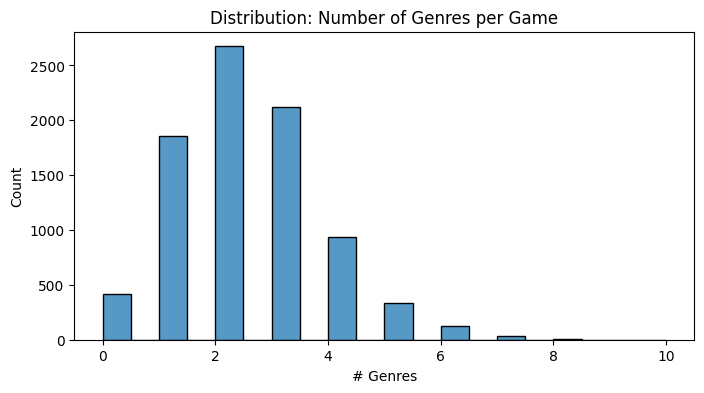

In [6]:
# Inspect Genre Feature Matrix

# Get an idea of the sparsity of the matrix
sparsity = 1 - (F.sum() / F.size)
print(f"Sparsity: {sparsity:.4f}")

# Plot number of genres PER game
num_genres = F.sum(axis=1)
plt.figure(figsize=(8,4))
sns.histplot(num_genres, bins=20, kde=False)
plt.title("Distribution: Number of Genres per Game")
plt.xlabel("# Genres")
plt.ylabel("Count")
plt.show()

In [7]:
# Build Genre Similarity Matrix and Distance Matrix
S = build_genre_similarity_matrix(games)  # cosine similarity
D = 1 - S                                 # cosine distance

Diagonal ~ 1: 0.9508389
Min similarity: 0.0
Max similarity: 1.0000001


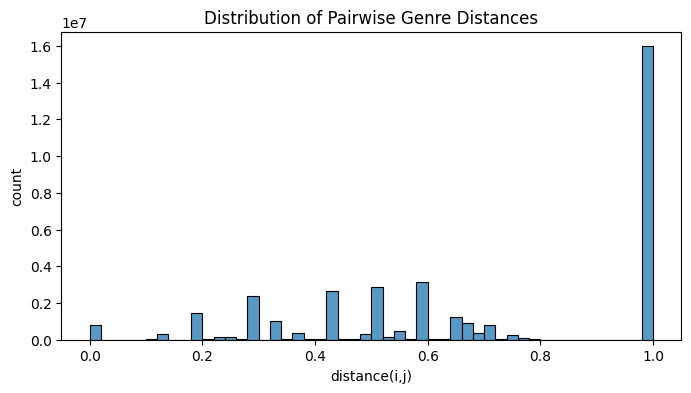

In [8]:
# Sanity check
## Similarity matrix
print("Diagonal ~ 1:", np.mean(np.diag(S)))
print("Min similarity:", S.min())
print("Max similarity:", S.max())

## Distance matrix distribution
### To get an idea if you pick e.g., two random games, how similar/distant are they?
plt.figure(figsize=(8,4))
sns.histplot(D[np.triu_indices_from(D, k=1)], bins=50)
plt.title("Distribution of Pairwise Genre Distances")
plt.xlabel("distance(i,j)")
plt.ylabel("count")
plt.show()

In [9]:
# Inspect Examples
## Most similar games
def most_similar(item_id, top=5):
    sims = S[item_id]
    idx = sims.argsort()[::-1][1 : top+1]
    return games.loc[idx, ["item_id", "item_name"]]

most_similar(10)

,item_id,item_name
1103,1103,Watch_Dogs™
124,124,Bully: Scholarship Edition
769,769,Legacy of Kain: Soul Reaver 2
768,768,Legacy of Kain: Soul Reaver
2080,2080,Litil Divil


In [10]:
## Most distant games
def most_distant(item_id, top=5):
    d = D[item_id]
    idx = d.argsort()[::-1][:top]
    return games.loc[idx, ["item_id", "item_name"]]

most_distant(10)

,item_id,item_name
6643,6643,Unseen Diplomacy
6098,6098,The Last NightMary - A Lenda do Cabeça de Cuia
6110,6110,The Grand Canyon VR Experience
3048,3048,War on Folvos
6108,6108,R.B.I. Baseball 16


In [11]:
import random

item_id = random.randint(0, len(games)-1)
history = random.sample(range(len(games)), 5)

novelty = D[item_id, history].mean()

print("Example item:", games.loc[item_id, "item_name"])
print("Example history:", history)
print("Novelty:", novelty)

Example item: Trials Evolution: Gold Edition
Example history: [6748, 2102, 6068, 5148, 7119]
Novelty: 0.74763966


In [13]:
# Save artifacts for later use
import os
output = "results/processed/"
os.makedirs(output, exist_ok=True)

np.save(os.path.join(output, "genre_features.npy"), F)
np.save(os.path.join(output, "genre_similarity.npy"), S)
np.save(os.path.join(output, "genre_distance.npy"), D)

print("Saved: feature, similarity, and distance matrices.")

Saved: feature, similarity, and distance matrices.


### Summary
- First, I inspected how many genres each game has. Most games have 1–3 genres, which confirms that a multi-label representation is meaningful.
- The distribution of pairwise distances shows one large mass at 1 (games with no shared genres) and a spread of values between zero and 1 for partially overlapping games, so the distance behaves as expected.
- Finally, I plugged this distance matrix into the item-to-history novelty definition and checked an example user to verify that the novelty scores are in a reasonable range and react to genre overlap.

### Conclusion
- We can use this genre-based distance matrix to compute item-to-history novelty scores for our recommendation experiments.